# PicTex Text Detection Model with Zach

Finalized on **August 21st, 2020**


### 1. Create labels

In [1]:
from collections import OrderedDict
import numpy as np
import torch
import os

data_dir = "./final_imgs/"

classes = os.listdir(data_dir)
num_classes = len(classes)

classes_encode, classes_decode = {}, {}
for i, name in enumerate(classes):
    classes_encode[name] = i
    classes_decode[i] = name

encode_dict, decode_dict = OrderedDict(classes_encode), OrderedDict(classes_encode)

print(f"There are {num_classes} classes")
print(classes_encode)
print(classes_decode)

There are 60 classes
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'alpha': 11, 'b': 12, 'beta': 13, 'c': 14, 'd': 15, 'e': 16, 'f': 17, 'forall': 18, 'g': 19, 'greater': 20, 'h': 21, 'i': 22, 'in': 23, 'int': 24, 'j': 25, 'k': 26, 'l': 27, 'lesser': 28, 'm': 29, 'mathds{C}': 30, 'mathds{N}': 31, 'mathds{Q}': 32, 'mathds{R}': 33, 'mathds{Z}': 34, 'n': 35, 'neg': 36, 'o': 37, 'p': 38, 'pi': 39, 'pm': 40, 'q': 41, 'r': 42, 's': 43, 'sim': 44, 'sqrt{}': 45, 'sum': 46, 't': 47, 'theta': 48, 'u': 49, 'v': 50, 'varepsilon': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55, '[': 56, ']': 57, '{': 58, '}': 59}
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'a', 11: 'alpha', 12: 'b', 13: 'beta', 14: 'c', 15: 'd', 16: 'e', 17: 'f', 18: 'forall', 19: 'g', 20: 'greater', 21: 'h', 22: 'i', 23: 'in', 24: 'int', 25: 'j', 26: 'k', 27: 'l', 28: 'lesser', 29: 'm', 30: 'mathds{C}', 31: 'mathds{N}', 32: 'mathds{Q}', 33: 'mathds{R}', 3

### 2. Create the `Dataset` and `Dataloader` objects

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import numpy as np
import torch
from PIL import Image
import random
import cv2

# grayscale images have one channel
num_output_channels = 1
normal = (0.5,)

# choose batch size
batch_size = 128

transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels),
     transforms.Resize((32, 32)), 
     transforms.ToTensor(),
     transforms.Normalize(normal, normal)])

class PicTexDataset(Dataset):
    def __init__(self, root_dir, encode_dict, num_classes, transform=None, train=True):
        """
        Args:
            root_dir (string): Directory containing images sorted by class folders
            encode_dict (Ordered dict): Dictionary with class names zipped from 0-(num_classes-1)
            num_classes (int): Number of classes (SHOULD EQUAL LEN of ENCODE_DICT)
            transform (torchvision.transforms): Transforms to be applied to images 
        """
        self.root_dir = root_dir
        self.encode_dict = encode_dict
        self.num_classes = num_classes
        self.transform = transform
        self.is_train = train
        
        """
        Loading images:
            all_paths (string list): Path of every image
            all_paths_class (string list): Bijection with all_paths. Class name for each path
            all_images (string * string list): List of these objects... (class name, path of image)
        """
        all_paths, all_paths_class = [], []
        for name in encode_dict.keys():
            list_classes = os.listdir(root_dir + name)
            all_paths += list(map(lambda s : root_dir + name + "/" + s, list_classes))
            all_paths_class += [name] * len(list_classes)
        
        self.all_images = list(zip(all_paths_class, all_paths))

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_class, img_name = self.all_images[idx]
        try:
            image = Image.open(img_name)
            if self.is_train:
                image = transforms.Grayscale(1)(image)
                image = self.random_shift(image)
                image = self.random_enlarge(image)
                image = self.random_noise(image)
            if self.transform:
                image = self.transform(image)
        except OSError:
            print(img_name, img_class)
        
        """
        label:
            If we wanted a tensor with a 1 in the spot of the class
            just uncomment the old label definition
            but NLLoss and CrossEntropyLoss just want the index
        """
        #label = torch.zeros(self.num_classes)
        #label[self.encode_dict[img_class]] = 1 
        label = self.encode_dict[img_class]
        return image, label
    
    def random_shift(self, img):
        if random.random() < 0.5:
            return img
        img = np.array(img)
        h, w = img.shape
        img_out = np.zeros((h, w), dtype=np.double)

        dx = random.uniform(-w*0.15, w*0.15)
        dy = random.uniform(-h*0.15, h*0.15)
        dx, dy = int(dx), int(dy)

        if dx >= 0 and dy >= 0:
            img_out[dy:, dx:] = img[:h-dy, :w-dx]
        elif dx >= 0 and dy < 0:
            img_out[:h+dy, dx:] = img[-dy:, :w-dx]
        elif dx < 0 and dy >= 0:
            img_out[dy:, :w+dx] = img[:h-dy, -dx:]
        elif dx < 0 and dy < 0:
            img_out[:h+dy, :w+dx] = img[-dy:, -dx:]

        img_out = Image.fromarray(img_out) 
        return img_out
    
    def random_enlarge(self, img):
        if random.random() < 0.5:
            return img
        img = np.array(img)
        k = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
        img = cv2.dilate(img, k, iterations=1)
        img = Image.fromarray(img)
        return img
    
    def random_noise(self, img):
        if random.random() < 0.25:
            return img
        img = np.array(img)
        img_copy = img.copy()
        gaussian_noise = img.copy()
        cv2.randn(gaussian_noise, 0, 45)
        img = gaussian_noise + img_copy
        img = Image.fromarray(img)
        return img
            
    
def load_split_train_test(datadir, valid_size = .2):
    dataset = PicTexDataset(data_dir, encode_dict, num_classes, transform)
    num_test = int(valid_size*len(dataset))
    num_train = len(dataset) - num_test
    
    train_data, test_data = random_split(dataset, (num_train, num_test))
    
    trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)


### 3. Test `Dataloader`

In [3]:
for image, label in trainloader:
    print(f"Label: {label}")

Label: tensor([17, 21, 12, 38, 47,  2,  2, 45, 18, 20, 54, 14,  9, 31, 34,  3, 21,  9,
        37,  0, 54, 21, 26, 31, 45, 43,  8, 18, 19, 55, 56, 37, 55, 55,  4, 34,
        59, 58, 19, 43, 30,  8, 43, 34, 56, 32, 22,  2, 23, 19,  2, 12, 34, 30,
         7, 52, 16, 35, 31, 25, 25, 13, 16, 45,  4, 45, 49, 48, 21, 44, 58, 55,
        53, 33, 54, 35,  0,  2, 54,  6, 50, 49, 17, 14, 33, 32,  3, 50, 22, 49,
         8, 34, 14, 34, 49, 56, 28,  6,  1, 12, 49, 12,  4, 38, 32, 14, 36,  1,
        48,  7, 31, 58, 53, 49,  8, 29, 45, 44, 32, 41, 15, 43, 29,  3, 52, 17,
         1, 55])
Label: tensor([42, 30, 33,  9, 32, 13, 54, 29, 41, 25, 36, 44,  7, 38, 32, 46, 53, 24,
        38,  8, 14, 28, 27, 37, 19, 25,  1,  4, 39, 38, 50, 13, 16, 14, 27, 42,
        10, 13, 58,  7, 48,  6, 27, 20, 44, 48,  8, 50, 49, 35, 45, 43, 16,  6,
        21, 47, 15, 39, 14, 10, 37,  1, 39, 24, 30, 54, 18, 34, 11, 52, 26, 53,
        13, 27, 45, 10,  0, 24, 13, 17, 29, 58, 43, 23,  0, 28, 17, 15,  7,  7,
         

Label: tensor([17, 35, 38, 17, 27,  9, 54, 17, 31, 45,  8, 35, 23, 23, 57, 45,  6, 28,
        14, 17, 53, 46, 28, 36, 16, 28, 22, 43, 45, 37, 24, 21, 19, 15, 41,  0,
        54, 15, 58, 39, 12, 46, 20, 47, 25, 11,  0, 52, 53,  8, 52, 25, 53, 45,
         3,  9, 27, 24, 19, 35, 35, 33, 20, 41, 37,  8, 50, 34, 11, 33, 40, 28,
         6, 25, 41, 13, 52, 25, 55,  6, 56, 16, 29, 48,  0, 21, 13, 41, 58,  3,
        38, 45, 23, 14,  8, 26, 45, 26, 23, 55,  9,  1,  9, 19, 19, 42,  3,  7,
        26, 47, 41,  3, 54,  0, 12, 31, 10, 15, 14, 40,  9, 26, 22, 15, 50, 58,
        40, 35])
Label: tensor([34, 56,  9,  2, 41, 31, 21, 40, 33, 48, 50, 52, 16, 53,  5, 49, 40,  4,
        23, 57, 15, 49, 28, 53, 20, 10,  3, 36,  7,  6, 26, 53, 12, 36, 34, 49,
         2, 55,  1, 27,  5, 11, 39, 20, 29, 51, 43, 26,  4,  3, 58, 35, 12,  1,
        31,  3, 16, 48, 17, 34, 51, 46, 48, 50,  7, 41, 33, 26, 10,  2, 53, 46,
        44,  4, 46, 37, 10, 33,  8,  3, 11, 12,  7, 19, 54, 38,  5, 19,  4, 46,
        1

Label: tensor([52, 23, 34, 11,  0, 58, 54, 22, 19,  2, 36,  2, 30, 38, 14, 49, 58, 14,
        16, 45, 59, 45, 20, 49, 16, 12, 20,  4,  9, 32, 21, 21, 19, 11, 28, 56,
        29, 26,  9, 34, 59, 10, 29, 46, 34, 16,  3, 36, 29, 35, 29,  3, 46, 52,
        19, 31, 27,  7, 19, 21,  8, 48, 42, 24, 57, 23,  9, 40, 19,  1, 10, 31,
        49, 23,  1, 27, 20, 52, 28, 27, 36, 29, 33, 19, 17, 57, 30, 26, 54, 34,
        35, 43,  5,  9, 17, 55, 52, 24,  0, 26, 22, 53, 45, 15, 27,  9, 37, 55,
        29, 16, 15,  2, 19, 19, 47, 35,  7, 26, 44, 21, 30,  0, 17,  6, 51, 49,
        12, 41])
Label: tensor([35,  8,  4, 34, 46, 11, 27, 45,  9, 26, 21, 45, 10, 58, 27,  7, 19, 17,
        52, 47, 59,  2, 12,  8, 55,  2, 55, 28, 22, 20, 12, 18, 48, 47, 33,  4,
        21, 15, 19, 27, 31, 41,  2, 35, 12, 21, 55, 43, 52, 36,  8, 49, 52, 49,
         5, 54, 59, 58, 52, 10,  8, 31, 20, 55,  9,  5, 48, 21,  4, 11,  5,  9,
        37, 32, 25, 36,  4, 27, 29, 52, 36, 40, 14, 13, 31,  8,  8, 33,  9, 15,
        3

Label: tensor([18, 55,  5, 29, 56, 54, 54, 50,  7, 18, 36, 16, 52,  9,  6, 11, 55, 55,
         7, 55,  2, 28,  0, 10, 55, 27, 47,  5, 55, 51, 51,  9, 17, 48, 29, 37,
        10, 43,  4, 14, 47, 47, 10, 10, 16, 15, 45,  3,  9, 22, 46, 50, 14, 25,
        53, 47, 24, 28, 25,  8,  4, 14, 21, 13,  3, 37, 33, 34, 50, 14, 27,  7,
        25, 16,  2, 42, 40, 25, 55, 41, 57, 23, 53, 38, 49,  2, 43, 37, 36,  7,
        51, 23, 16, 41, 35, 51, 25, 11, 46, 27, 17,  6, 38,  4, 54, 35, 18, 53,
         9,  1, 26, 51, 18, 33, 28, 32,  9,  8, 47, 42, 19, 10,  7, 22, 24, 29,
        27, 55])
Label: tensor([34, 50, 21, 43, 49,  1, 27, 38, 21, 29, 23, 27, 40, 55, 25, 28, 53,  6,
         1, 25,  1, 18, 25,  9,  1,  6, 12, 20, 18, 24, 10, 10, 34, 20,  9, 16,
        45,  8, 43, 13,  6,  0, 28,  2, 40, 25, 16, 38, 20, 42, 33, 31, 29, 52,
        43, 53, 42, 12, 31,  8, 35, 36, 56, 40, 55,  2, 38, 38, 19, 41, 55, 19,
         7,  4,  7, 46,  6, 42, 13,  4,  0, 29, 34, 35, 55, 45, 31, 17, 41, 23,
        5

        15, 46])
Label: tensor([54,  0, 43, 47, 30,  3,  4,  6, 14,  3, 35,  6, 33, 21, 58,  0, 35, 58,
        43, 37, 15, 28, 38,  7,  1, 28, 21, 16, 25,  8, 48,  2,  5, 24, 16,  7,
         3,  5, 42, 54, 43, 37, 25, 16, 17, 39, 54, 21, 15, 50, 22,  4,  6, 10,
         8, 16,  0,  0,  3, 35, 14, 48, 47, 25, 17,  6, 34, 38, 22, 44, 50,  8,
        36,  7, 53, 20, 38, 46, 25,  1, 14, 58, 26, 24, 44, 38,  4, 23, 15, 56,
        45, 21, 21, 48,  4, 54, 21, 54, 31, 33,  6,  4, 53, 47,  4, 17, 46, 27,
        11, 19,  3, 22, 39,  9, 20, 15, 18, 16,  3,  3, 19, 50, 48, 18, 23, 34,
        34, 53])
Label: tensor([37, 43, 25, 51, 29,  0, 21, 36, 11, 53, 15, 26, 15, 53, 15,  0, 55, 42,
        46, 14, 14, 15,  2,  5, 44, 52,  1, 54, 14, 48, 55, 12,  1, 21, 50, 38,
        42, 15, 17, 40, 49, 19, 40, 11, 47, 25, 42, 51, 14, 10, 42, 14,  8, 52,
        28, 40, 38, 17,  5, 54, 46, 19, 56, 48,  9, 55, 13, 25,  6, 40, 54, 58,
        58, 28, 14, 53, 15,  6,  8,  2, 35, 57, 17, 21, 47,  7, 53, 12, 

Label: tensor([ 6, 44, 52, 34, 30, 33, 50, 58, 42, 34, 43,  3, 26, 21, 47,  6, 37,  5,
        37, 32,  2,  2, 41,  6, 15, 41, 17, 30,  1, 17,  9, 14, 15, 54,  5, 43,
         9, 42, 19,  0,  1, 49, 18, 26, 17, 21,  4, 47,  7, 48,  1, 47, 12,  0,
        25, 55,  3,  5,  9,  1, 23, 20, 11,  7, 23, 19, 11, 36,  6, 27,  3, 33,
         0, 25, 47, 58, 42, 14, 10,  0, 53, 46, 15, 50, 44, 17, 30, 35, 18, 19,
        58,  9, 41, 58, 51,  5,  3, 16, 14, 26, 10,  3, 31, 52, 28, 37, 21,  9,
        56, 44, 13, 10, 13, 43, 26, 37,  7, 22,  6, 41,  3, 24, 43, 55, 46,  2,
        38, 49])
Label: tensor([47, 34, 35, 27, 18,  1, 14, 48, 53,  7,  3, 15, 19, 24,  8, 20, 54, 21,
        20, 53, 23, 22, 52,  9, 48,  1, 56, 53, 42, 56, 27, 35, 33, 54,  8,  0,
        37, 43, 47, 54, 11,  2, 41, 55,  2,  3, 24, 10,  2, 24, 28, 10, 38, 26,
         9, 38, 49, 43,  9, 47, 24, 30, 47, 23, 55, 25, 58, 11,  8, 41, 23, 50,
        35,  8, 45, 48,  2, 13,  2,  6, 14,  4,  9, 35, 58, 55, 46, 48, 58,  9,
         

        26, 17])
Label: tensor([47,  0, 14, 16, 47, 35, 46,  5, 35, 44, 58, 21, 55, 10, 20, 11, 12, 29,
        56, 38,  3, 58, 12,  9, 14,  5,  7, 44,  7, 48, 51, 11, 16, 41, 46,  1,
        14, 43, 48, 10, 53, 25,  4, 43,  1,  9, 31, 50, 47, 20, 58, 47, 18, 23,
        47, 22,  1, 33, 26,  7, 20, 47, 16,  7, 27, 21, 23, 18,  2, 31,  6,  1,
        17, 23,  7,  9, 14,  7, 16, 52, 18, 55,  7, 38,  2,  4, 22, 44, 27, 12,
        28,  8, 37, 43, 49, 35, 21, 25, 25, 31, 26,  1, 28, 28,  4, 50, 37, 47,
        18,  8,  5, 22, 46, 22, 46, 14, 22, 43, 16, 55, 40, 41,  2, 58, 44,  4,
        58, 33])
Label: tensor([21, 49,  5,  8, 15, 11, 42, 54, 55,  0,  9, 24, 10, 33,  4, 44,  8, 35,
        41, 38,  1, 35,  6, 12, 25, 17,  4,  8, 50, 10, 36, 10, 47, 49, 47, 28,
        18, 53, 45, 14, 13, 56, 45, 55, 53, 56,  9,  9,  5, 53, 56, 38, 23, 57,
         5,  7, 38,  9, 31,  7,  0,  8, 26, 47,  1, 45, 17, 18, 43, 55, 52, 25,
        26,  5,  7, 10, 33,  0, 58, 25, 25, 48, 48,  4, 48,  7, 54, 16, 

        55, 32])
Label: tensor([58, 33, 58,  7, 45, 47, 44, 52,  8,  5, 50, 53, 42,  9, 19, 26,  8,  5,
        35, 33, 45, 46,  2, 26, 28, 35,  2,  5, 28, 14, 12, 42, 53, 26, 57, 17,
         3, 37, 42,  1, 15, 50, 31, 19, 58, 58, 34,  7, 28, 42, 48, 46, 58, 43,
        20,  5, 44, 52,  6, 22, 16,  4, 24, 29,  2, 20, 38, 13, 27, 31, 49, 47,
         0, 42, 14,  6, 27, 59, 39, 12, 11, 56, 55, 47, 28,  7,  5, 27, 49, 45,
        17, 19, 43, 23, 44,  7,  2,  4,  6, 11, 37, 19, 12, 47, 15, 59, 23, 21,
        58, 43, 34, 25, 14, 16, 54, 55,  4, 12, 21, 19, 36,  6, 36, 16, 27, 41,
        46,  7])
Label: tensor([23, 46, 47, 38, 18, 36, 39, 54,  1, 12, 50,  8, 12, 30, 28,  8, 27, 51,
        41, 38,  9, 10,  8, 39,  1, 59, 23, 28,  8, 53, 12, 10, 48, 41, 21,  7,
        47, 17, 22, 43, 55, 47, 39, 47, 16, 40, 38, 14, 53,  1, 24, 19,  5,  6,
        29,  3, 49, 27, 48, 56, 16, 52,  2, 40,  7, 27, 10,  6, 34, 37,  1,  0,
         6, 58, 56,  9, 44, 11, 31, 27, 47, 43, 55, 12, 35, 10, 52, 26, 

Label: tensor([ 9, 17, 15, 52, 11, 50, 43, 21, 28, 15, 23, 48, 27, 23, 29, 38, 21, 20,
        44, 50, 53, 38, 16, 56, 53, 51, 41, 28,  9, 36, 41, 21, 26,  3, 12, 34,
        58, 58,  9,  1, 21, 46, 30, 34, 41, 26,  6, 25, 43,  4, 56, 43, 43,  7,
         7, 25, 38, 20, 24, 17,  0, 42, 47, 11, 47, 24,  4,  1,  2, 15,  4, 30,
         0,  2,  9, 27,  8,  2,  7, 48, 12,  6, 43,  9,  5, 15, 28, 11, 29, 14,
        26,  4,  1, 58, 40, 43,  2, 28,  5, 11, 10, 48, 42, 41, 34,  5, 14, 27,
        56,  3, 33,  1, 40, 48, 46, 39, 28, 29,  5,  6, 18, 16, 19, 46,  1, 42,
        14, 37])
Label: tensor([ 0,  0,  7, 50, 13, 47, 34, 34, 37, 53, 50,  3,  6, 18, 18, 27, 11, 27,
        13,  5, 46, 44,  5, 43,  1, 59, 49,  1, 18, 25, 52, 24, 35, 56, 27, 19,
        13, 37, 43, 10, 43, 31, 14, 55, 26, 37, 53, 20, 17, 10, 17, 54,  6, 47,
         7, 10, 54, 10,  2,  0, 25, 46, 30,  8, 27, 56, 33,  1,  4, 43, 10, 51,
         6, 29, 45, 20, 35, 26, 59,  2, 48, 29,  2, 20, 54, 10, 14, 20, 41, 10,
        5

Label: tensor([12, 23, 46, 19, 49,  6, 36,  0,  6, 42, 13, 39, 30, 37, 41,  7,  6, 18,
        19, 42,  0,  2, 50,  0,  1, 51, 54,  3,  2, 52, 12, 25, 55, 36, 58, 21,
        43,  9, 56, 12,  8,  6,  6,  9, 48,  4,  8, 11,  5, 33, 43, 51, 54,  4,
        21, 13, 53,  3, 37, 12, 40, 51, 10, 42, 17, 22, 27,  3, 58, 41, 23,  6,
         6, 10, 58,  4,  4, 25, 50, 10, 38, 38, 41, 55, 16,  9, 45,  5, 28, 42,
        18, 47, 25,  1, 52, 44,  1, 18, 25, 52, 39, 22, 25, 20, 54, 39, 16, 25,
        49, 56, 18, 14, 38, 48, 31, 21, 19,  3, 40, 35, 19,  7, 13, 27, 26, 41,
        40,  3])
Label: tensor([57,  8, 11, 38, 10, 52, 43,  1, 34, 10,  0, 54, 21, 12, 21, 28, 59, 47,
        22, 50, 15, 15, 33, 41,  5,  4, 51, 46,  1, 42, 55, 31, 11, 14, 23, 53,
        44,  1, 12, 49,  4, 43, 13,  8, 50,  6, 50, 28, 23,  7, 38, 14,  9,  4,
         5, 51, 30, 58, 27, 18, 41, 49,  7, 22, 23, 20, 41, 15, 24, 37, 44, 42,
        19,  6, 26, 19, 27, 55, 14, 18,  2,  8,  5, 10, 37, 43, 43, 18,  8, 56,
        5

Label: tensor([53, 11, 15, 55, 18, 50, 52, 54, 42,  2, 55, 53, 13, 18,  9, 57, 44, 37,
         2, 56, 56, 22, 41, 55, 54,  4,  1, 21,  7,  5, 15, 12,  3, 15, 28, 41,
        37, 20, 10, 52, 15, 14, 37,  6, 23, 15, 25, 46, 34, 18, 36, 49, 24, 35,
        58, 25, 47, 47, 47, 43, 12,  8, 54, 11, 23, 17, 54,  4, 42, 37, 17,  5,
        54,  2,  1, 28, 11, 43,  7, 46, 17, 19, 21, 30, 12, 33, 19, 26,  0,  7,
         1, 28, 12, 12, 41, 31, 34, 19, 21,  9, 23, 16, 57, 41, 34, 47, 49, 53,
        55, 31,  4, 17, 14, 39, 53, 41, 10,  6,  7, 43, 22, 21,  6, 50, 24, 25,
        55, 20])
Label: tensor([50, 49, 22,  4, 52, 13,  8, 14, 37, 41, 55, 28, 15, 22, 46, 42,  7, 18,
         0,  5,  8, 49, 50, 48, 51,  6, 34, 10,  7, 16, 16, 40,  0, 16, 50,  0,
        39, 53,  6, 37,  2, 38, 30, 36, 27, 16,  8, 22,  9, 15, 38, 51, 28, 21,
        55,  4, 16, 17, 51,  0, 11, 25, 48,  6, 15, 43, 15, 15, 59, 54, 20, 43,
        13,  3, 50, 44, 33, 13, 34, 54, 37, 15,  1, 13, 28,  7,  0, 41, 54,  6,
        1

Label: tensor([38, 39, 54, 43,  2, 55,  1, 26, 50,  4, 45, 56,  1,  6, 12,  2, 15, 29,
         9, 49, 10, 43, 19, 25, 52, 48, 58,  6, 12, 11, 25, 19, 37, 21, 43, 26,
         3,  2, 53, 58,  9, 43, 49, 14, 46, 47,  8, 55,  7, 22, 35,  1, 24, 48,
        29, 14, 21, 23,  6, 30, 14, 41,  3,  1,  1, 31, 10, 56, 50, 18,  6, 26,
        48, 46, 49, 16, 24, 26,  5,  3,  1, 12,  5, 55,  5, 16,  6,  8, 16, 54,
        39, 20, 23, 28, 55, 53, 58, 13, 52, 45, 31, 40, 37, 38, 35, 39,  9,  4,
        38, 28, 10, 13,  8, 24, 37, 36, 45, 16, 46, 17, 29, 23, 35, 29, 25,  8,
        48, 51])
Label: tensor([33, 12, 26, 28,  6, 15, 44, 42,  1, 45, 19, 46, 24, 23, 41, 19, 24, 27,
         3, 35,  8, 24, 59,  6, 47,  4, 54, 38, 42, 56,  9,  6, 29, 20, 42, 55,
         1,  3,  1,  4, 26, 37, 38, 49,  5, 43, 15, 55, 46, 22,  1, 14, 48, 58,
         0,  7,  1, 43, 28, 34, 21,  5,  3,  6, 43, 51,  6, 36, 14, 31,  2, 34,
        49, 50, 25, 29, 38, 25, 20, 43, 49,  0, 29, 26,  1, 29, 27, 33,  9, 31,
        1

Label: tensor([31, 36, 48, 38, 54,  6, 42, 21,  0, 22, 47, 40, 14, 21, 39, 54, 48, 26,
         5, 58,  8, 50,  4, 41, 19,  2, 53, 42, 39, 14, 54,  6, 49, 27, 41, 46,
         7,  2, 17,  0, 24, 36, 24, 17, 18, 53, 27, 36,  0, 17, 29, 44, 32, 52,
        52, 52,  6, 31, 47, 35, 47,  9, 28, 34, 35,  5, 28, 47, 48,  0, 58,  2,
        58,  2,  6, 43,  3, 13, 36, 23, 10,  7, 53, 28,  9, 26,  9, 25, 41, 54,
        15,  3, 20, 12, 56, 54, 46, 21, 14, 59,  6, 42, 10, 59,  1,  8,  6, 27,
         9, 18,  9, 44, 35,  1, 58, 41,  2, 26, 41, 20, 28, 53, 40, 39,  9, 16,
        43, 48])
Label: tensor([22,  3, 33,  9, 49, 41, 28, 16,  7, 38,  3,  5, 49, 43, 15,  4,  6, 11,
        33, 50, 46, 50, 34, 47, 45, 53, 27, 13, 52,  4, 56, 41, 14, 39, 12,  2,
        45, 58, 25,  8, 40, 12, 10, 24, 22, 17,  6, 55, 56,  4, 42, 16,  4,  7,
        42,  5,  9, 29,  7, 55,  0, 27, 40, 52, 55,  3, 24, 49, 36, 34, 37, 16,
         1,  8,  2, 43, 14, 34, 53, 50, 13, 14, 19,  1,  3, 42, 29, 48, 49, 15,
        1

Label: tensor([12, 47,  1, 47,  9, 48, 36, 50, 26, 29, 50, 19, 51, 13, 44, 47, 55, 37,
        12, 23, 42, 55, 52,  1, 19, 14, 36, 11, 14, 52, 35,  5, 25, 40, 50,  9,
         0,  8, 37, 44, 30, 53, 53,  8, 26, 39,  6,  6, 50, 17, 33, 35, 50, 55,
        15, 53, 11, 21, 28, 54, 28, 48, 37, 54, 56,  9, 29, 16, 18, 55, 53, 29,
        52, 55, 48, 27,  2, 26, 16, 50, 38, 20, 33,  9, 11, 39, 29,  6,  6, 52,
        43, 47, 24,  9, 55, 15,  4,  3, 14, 23, 25, 55, 55, 41, 41,  3, 45,  1,
         6, 14, 21, 54, 23, 55,  4,  8,  4, 17, 35,  2, 12, 18, 22, 42, 58, 13,
        40, 26])
Label: tensor([46, 45,  3, 51, 29, 16, 16, 22, 38,  5,  3, 54,  3, 42, 43, 56, 28, 40,
         7, 12, 22,  1, 12, 15,  3, 29, 22, 49, 29, 21, 51, 15,  3, 54,  7, 10,
        11, 18, 14, 17, 33, 10,  0,  0, 33, 19,  8,  6, 36,  7,  3,  0, 14,  1,
        36, 50, 10, 19, 15, 31,  4, 38, 41, 57, 23, 14,  3,  7, 21,  8, 22,  2,
        45, 38, 58, 29, 52, 55, 52, 46,  0, 39,  8, 27,  9, 42, 26, 16,  9,  4,
        2

Label: tensor([19, 25, 16, 19, 22, 55, 49, 36, 34,  6,  5, 28, 18, 10, 48, 27,  2,  8,
        22, 42, 14, 34,  6, 35, 15, 47, 45, 12, 37,  7, 49, 37, 21, 12,  0, 39,
        37, 25, 27, 46, 10, 23, 30,  4, 50, 55, 54, 38, 12, 21, 58, 50, 10, 29,
         0, 36, 41,  6, 16,  7, 42, 33,  8, 11, 34,  7, 37, 17, 55, 48, 38,  2,
         8, 25, 19, 49, 10,  6, 55, 36, 24, 13, 29, 50, 55, 40, 48, 23, 16, 33,
        34, 53,  4, 55,  7, 47, 42,  4, 21, 25, 25, 34,  4, 50, 35, 44, 15, 12,
        52,  1, 59,  6,  9, 21, 50, 14, 58, 34, 42, 22, 26, 28, 51,  6,  3, 48,
        11, 28])
Label: tensor([ 3, 56, 46, 42, 46,  3, 40, 12,  4, 55,  0, 47, 40, 10, 46, 24, 27, 42,
        49, 27,  8, 58, 14, 58,  8,  9, 47, 37, 55, 34, 36, 37, 37, 40, 54, 17,
         1, 21, 41, 51, 14, 17, 27,  1,  1, 11, 58, 54, 38, 56, 29, 26, 45, 39,
         4, 32,  0, 37,  2, 41, 21, 18, 43, 26,  0, 15, 46, 20, 19, 47,  1, 21,
         2, 28, 24,  9, 38, 34,  4, 38,  9, 18, 21, 30, 15,  0, 54, 26, 19,  2,
        1

Label: tensor([34, 25,  5, 21, 53, 56, 13, 45, 40, 47, 24, 38, 12,  7, 34, 48, 48, 55,
        21, 43, 41, 41, 52, 56,  9,  8, 11,  8, 56, 58, 50, 41, 58, 22, 53, 18,
         5, 51,  7, 47, 20, 48, 10,  9,  3, 46,  5, 20,  1, 41, 21,  4,  8, 17,
         6, 27, 40, 27,  2, 23,  7,  8,  8, 27, 22, 56, 47, 22, 37, 47, 38,  7,
        50, 26, 25, 22, 14, 40, 22, 14, 50, 14, 16, 17, 24, 31,  8, 31, 31, 40,
        10, 30, 28,  7, 37, 53, 50, 54,  0, 37, 34, 52, 50, 13, 12, 20, 34,  9,
        50, 43, 58,  9,  2, 11, 19, 35, 46, 14, 12, 35, 50, 28, 38, 16, 31, 23,
        33, 28])
Label: tensor([16, 16,  5, 41, 48, 58, 38, 14, 47, 17,  2, 31, 53,  0, 47, 22,  5, 49,
        17, 29, 19, 41,  9, 34,  2, 47, 42, 24,  8, 17, 58, 55, 14, 20, 49,  7,
        25, 37, 42, 41, 56, 14,  0, 41,  1,  0, 48, 43,  7,  8, 22,  2, 16, 41,
        40,  9, 13, 26,  8, 26,  3, 16, 47,  3, 45,  8, 26,  2, 36,  2, 58, 21,
        46, 52, 50, 42, 39, 32,  6,  3, 59, 46, 16, 10, 38, 51, 48,  0, 54, 10,
         

Label: tensor([23,  2, 44, 52, 41, 43, 34, 54,  5, 33, 19, 15, 37,  4, 42,  0, 36, 55,
        36, 58, 23,  7, 50, 17, 24, 16, 24, 52, 56, 16, 24, 43, 14, 17, 18, 36,
        18, 31, 54, 18, 28, 47, 37, 29, 54, 26, 21, 24, 10, 55,  1, 58, 15, 50,
         5, 31, 34, 58,  4, 37, 41, 34,  1,  0, 58,  6,  6,  0, 35, 27, 23, 46,
        29, 33,  1, 41, 58, 19, 55, 39, 10, 56, 58, 15, 47, 26, 31, 42, 38, 58,
        55, 54, 18, 12, 33, 12, 15, 49, 19, 18, 19,  7, 31,  2, 48, 41, 40, 42,
        42, 24, 56, 42, 29, 26, 48,  9, 26, 12, 31, 58, 56, 40, 28, 59,  9, 21,
        38, 37])
Label: tensor([50, 24, 23,  7, 29, 16, 38,  5, 16, 35, 59, 53, 26, 29, 42, 33, 27, 29,
        28, 23, 44, 25, 10,  2, 35, 17,  9,  3,  2, 48, 34, 26,  8, 36, 24,  1,
         8, 45, 30, 30, 10,  6, 17, 36, 42, 29, 35, 14, 24, 26,  8,  5,  2, 43,
        20, 42, 43, 55, 38,  5, 23, 34, 12,  3,  9, 22, 32, 44, 49, 31, 39, 22,
        17, 46, 21, 33,  1,  5, 21, 14,  1, 22, 42, 42, 35, 12, 15, 26, 37, 21,
        5

Label: tensor([15,  3, 23, 43, 31,  8, 24,  7, 14, 36, 19, 14, 38, 37,  0,  3, 47, 39,
        26,  8, 41,  9, 49, 49, 23, 25, 13, 47, 36, 42, 41,  0,  4, 28, 17, 47,
        15, 14, 19, 39, 42, 44, 48, 44, 22, 17, 53,  1, 26, 40, 21,  2, 45,  8,
         5,  1, 39, 53, 22, 35, 32, 25, 45, 25, 25, 21, 53, 19, 34, 56, 16, 15,
        45, 11, 24, 15, 47, 39,  4, 40, 20, 19,  2,  5,  9, 46, 39,  6, 52,  1,
         7, 35, 26, 22,  1, 35, 33, 21, 47, 10, 54,  9, 20,  3, 33, 35, 24, 37,
        36, 29, 40, 53, 48, 33, 12, 51, 30, 26, 56, 51,  6, 49, 44,  9, 41, 47,
        23, 29])
Label: tensor([34, 13,  5,  0, 11, 17, 38, 21, 29,  6, 53, 22, 58, 29,  6,  2, 31, 21,
         5, 50,  8, 45,  4, 51, 15, 23, 10, 46, 27, 23,  3, 21, 56, 21,  5,  5,
        47,  7, 19,  7, 33, 28, 43,  7, 52,  7, 14, 22, 37, 18, 24, 10, 40, 29,
        11, 35, 36,  2, 19, 57,  6, 50, 29, 53,  0, 12, 22, 16, 47, 57, 58, 50,
        48,  6, 15, 53,  2,  2,  9, 52, 37,  5, 25, 28,  3, 52, 15,  3,  7, 45,
         

Label: tensor([ 4,  8, 29, 36, 56, 29, 42, 45,  2, 37, 14, 38,  2, 30, 19,  8,  0,  9,
        41,  9, 17, 35, 19,  0, 16,  5, 53, 19, 34, 46, 55, 52, 14, 56, 14, 48,
        25, 43, 41, 41, 41, 53, 16, 12,  3, 26, 37, 24,  1, 29, 43, 56, 49, 47,
        21, 31, 22, 31, 46, 47, 15, 25, 32, 43, 29, 49, 20, 50, 43,  1, 35, 39,
        43, 16, 58, 29, 40, 37, 30, 53,  0, 43, 12, 50, 16, 48, 58, 23, 50, 25,
        11, 55, 16,  4, 45,  0, 45, 58,  3,  4, 28, 36, 33, 50, 19, 14,  1, 24,
        18, 29, 33, 53, 12, 46, 26,  5, 37, 43, 35, 28, 53, 22,  5, 52, 29, 41,
        28,  8])
Label: tensor([35, 21, 46, 58,  0, 14,  4, 42, 26, 49,  3, 14, 36, 53,  2, 16, 58, 16,
        55, 37, 43, 43, 50, 15,  8, 25, 26,  2, 56, 41, 32, 16, 28, 24, 56, 35,
        38, 45, 18, 12,  5, 37, 14,  1, 54, 23, 17,  1, 44, 16, 49, 13, 34, 23,
        42, 55, 16, 50, 37,  6,  8,  6, 24, 51, 22,  6, 45,  6, 33, 27, 49,  2,
        48, 17, 15,  5, 38,  4, 35,  3, 53, 33, 50, 27, 39, 20, 59, 36,  9, 23,
        1

Label: tensor([17, 50,  8, 46, 27, 23,  3, 22, 22, 36, 49,  6, 13,  1, 41, 41, 15, 51,
        35, 10, 50,  6, 10, 33, 37, 58,  9,  9, 13,  6, 41, 59,  2,  9,  1, 25,
         1,  9, 38, 21, 17, 54, 15, 15,  2,  6, 55, 14, 48, 17, 34, 12, 49,  3,
        34,  7, 11,  5, 48, 23, 11, 26, 48, 13,  2, 27, 15, 18, 10, 27,  6, 17,
         0,  7, 44, 47, 22, 14, 48, 55, 46, 50,  7, 48, 39, 17, 29,  6,  1, 29,
        37, 49,  3, 47, 24, 25,  5,  6,  1, 29, 31,  9, 13, 15, 19, 11,  7,  8,
        36, 52,  9, 53, 16, 13, 25, 50, 59, 29, 24, 52, 17,  2, 10, 37, 26, 31,
        21,  6])
Label: tensor([ 1, 15,  1, 45, 53, 15, 45, 49, 55, 52, 41,  3, 38,  1, 13, 34, 24, 13,
        29, 26, 24, 41, 38, 35, 23,  5, 41, 53, 47, 13, 38, 32,  0,  6,  3, 30,
         1, 47, 53, 25, 35, 26, 41, 50, 35, 16, 47, 44, 16, 24, 55, 33,  1, 26,
        44, 49, 35, 10, 26, 17, 16, 25, 31, 33, 49, 25, 14, 53, 13, 41, 21, 17,
         4, 48, 26, 18, 50, 44,  9, 49, 31, 45, 14, 17, 41, 25, 50, 52, 36, 50,
         

Label: tensor([28, 39, 39, 29,  2, 59, 33,  4, 14,  6, 49, 35,  3, 14,  6, 53, 51,  8,
        53, 29, 52, 29, 22,  9, 35, 55,  1, 36, 48, 39, 38, 21, 28, 10, 53, 34,
        10,  7, 16, 53, 26, 15, 19, 35,  1, 38, 42, 36, 50, 24, 27,  6, 26, 47,
        25, 47, 43, 41, 46, 35, 26, 20, 40, 20,  0, 35, 10, 56, 26, 28,  9, 37,
        18,  7,  1, 34, 48, 38, 28, 25, 28,  1, 19, 58, 55,  0, 10, 29, 43, 57,
         3, 36, 35, 24, 38, 15,  3,  1, 48, 39, 22, 59, 58, 12, 35,  3, 55, 38,
        20, 49, 16, 49, 26,  2, 45,  1, 17,  9, 50, 41, 53,  1, 50, 52,  7,  3,
         9,  7])
Label: tensor([15, 25, 12, 19, 53, 52, 18, 29, 22, 12, 44,  4, 11, 10, 46,  6, 34, 45,
        53, 57, 11, 30, 34, 53, 34, 18, 50, 50, 25, 19, 18, 17, 22, 38, 13, 19,
        41, 12, 28, 19, 27,  8, 58, 55, 54, 37,  3, 26,  2, 38, 50, 20, 38, 31,
        16, 49, 22, 20, 22, 52, 34, 34, 26, 41, 43, 24, 28,  8, 47, 46,  5, 22,
        10, 12, 55, 46,  0, 31,  0,  4, 12, 44,  5, 39, 48, 54, 55, 12,  7, 41,
        3

Label: tensor([25,  4, 37, 17,  0, 56, 45, 51,  3, 44, 15, 33, 27, 51, 42,  4, 29, 53,
        52, 26, 54, 38, 46,  9,  0, 40, 24, 42, 25, 14,  3,  6, 35,  1,  0, 15,
        53, 24,  8, 49, 49, 38, 39, 19, 17, 17, 35, 42,  5, 50,  3, 53, 17, 53,
        41, 53, 54, 38, 11, 59,  2, 19, 13, 26, 46, 15, 15, 50, 21, 50, 10, 12,
        50, 49, 14, 43, 22, 54, 45,  8, 54, 58, 35, 28, 22, 42, 19,  4, 16, 14,
        41, 53, 54, 50,  6, 50, 15, 17, 46, 38, 15, 38, 47, 33, 17,  3,  6, 33,
        38, 24, 49, 52, 59, 29, 30, 50,  1, 46,  1, 54,  8, 53,  7, 23, 46, 25,
        12, 14])
Label: tensor([20, 13, 47, 11, 41,  4, 22,  7, 36, 44, 38, 25,  7, 44, 27, 15, 23, 41,
        25, 19, 15, 18,  8, 18, 43, 43, 23, 15, 18, 14, 47, 26, 42, 22,  9, 41,
         9, 53, 29, 58, 55, 31, 15, 36, 53, 14, 51, 55, 36, 38, 50, 27, 56, 37,
        54, 22, 13, 53,  5, 38, 37, 37, 42, 53, 11, 18, 38, 53,  9, 49, 43, 52,
         6, 26, 58, 24,  2, 19, 43, 47, 48, 51, 25, 25, 40, 16, 10, 45, 13, 17,
        1

Label: tensor([20,  0,  3,  4,  1, 15, 15, 41, 45,  5, 34, 48, 10, 41,  1, 26,  0, 10,
         1, 35, 26,  5, 50,  2, 20,  5,  6,  6, 21, 16,  6,  5, 27, 53,  8, 24,
        53, 14,  5, 13, 22, 21, 34, 25, 12, 17,  7, 31, 49, 51,  4,  3, 57, 49,
        27, 11, 51, 10, 39,  4,  0, 21, 53, 43, 23, 25, 53, 49,  5, 47, 41, 26,
         8, 25, 42, 36, 51, 21, 21, 15, 16, 36, 33,  7, 15, 37, 51, 46, 34, 44,
        46, 46, 48,  4, 29, 56, 22, 15, 53, 42, 56, 43, 10, 27, 31, 35,  9, 13,
        42, 41,  2, 47, 26,  9, 33,  7,  3, 47, 17, 24,  0, 44, 35,  6, 45, 35,
        51,  0])
Label: tensor([43, 28, 46,  1, 37, 27,  7, 22, 40, 49, 10, 37, 46, 11, 28, 49, 45,  0,
        17, 18,  2, 36, 48, 28, 29, 56,  5,  1, 37, 50, 58,  8, 11, 31, 48,  8,
        18, 23, 17, 34, 43, 55,  6, 15,  1, 34, 41, 12,  2, 54, 29,  5, 30, 31,
        20, 37, 21,  0, 26, 39, 23, 37, 19,  6, 42,  3,  1, 39, 38,  7,  7, 54,
        47, 47,  8, 56, 12, 30,  7, 17,  8, 46, 17, 24,  8,  4, 45, 54,  7,  6,
        3

Label: tensor([47, 12,  0, 35, 33, 21, 37, 53, 14, 52, 42, 50, 22, 14, 32,  9, 26, 29,
        46, 48, 49, 55, 52, 25,  4, 48, 31, 24,  0,  7, 49,  2, 40, 29, 46, 38,
         4,  0, 22, 42, 42, 38, 43, 50, 37, 43, 37, 42,  0, 31,  0, 21, 50, 46,
        40, 46, 43,  6, 16, 14,  8, 15, 52, 54, 27, 15, 31, 27, 57, 35,  5, 10,
        25, 11,  7, 21, 42,  2, 31, 51, 24, 14, 22, 35,  4, 49, 42, 26,  6, 48,
        14, 54, 37, 33, 12, 44,  1,  5,  6, 26, 44,  4,  3, 25, 59, 35, 29, 30,
        44, 17, 46, 15, 40,  0, 19, 50, 46,  6, 31, 44, 23, 40, 38, 21, 13, 50,
        16, 41])
Label: tensor([39, 20, 53, 51, 12, 51,  0, 14, 20, 22, 58, 42, 21, 23, 26, 24, 49, 41,
         6,  6, 24,  7, 46, 11, 44, 38, 25, 41, 53, 17, 27, 48,  5,  8,  2,  7,
        25, 13, 49, 41,  7,  7,  3, 11, 53, 30, 13, 36,  8, 47, 29,  4, 18, 14,
        22,  7,  9, 41, 10, 41, 33, 13, 26,  0, 11, 49,  7, 55,  6, 52, 52, 24,
        50,  9,  6,  2,  4, 36, 14, 47, 28, 34, 20, 28, 49,  6, 22, 27,  2, 19,
        3

Label: tensor([55, 55,  8, 31, 32,  9,  4, 42, 42, 37, 23, 17, 17,  8, 17,  2, 18, 11,
        52, 25, 10, 19, 54,  0, 28, 52, 31,  5,  8, 51, 37, 46, 16,  6, 43, 34,
         4, 45, 42, 53, 41,  0, 20, 36, 15, 17, 27, 26, 49, 22, 27, 48, 41, 51,
         6, 29, 55, 14, 29,  6, 13, 53, 29, 27, 37, 48, 12, 49, 21, 17, 30,  4,
         5, 37, 52, 44,  8, 19, 50, 23, 32, 14, 55, 12,  3,  6, 16, 44, 50, 53,
        32,  7, 16, 35,  8, 29, 33,  5, 10, 35,  1, 17, 40, 37,  3, 12, 19, 31,
        29, 24, 45, 21, 28, 49,  8, 48, 14, 51, 37, 10, 47, 29,  8,  9, 48, 53,
        53,  6])
Label: tensor([16, 44, 53, 52, 49, 41, 43, 31, 52, 38, 51,  2, 23, 27, 21, 21, 35, 49,
        13, 18,  5, 52, 37, 43, 50, 22, 41, 20, 24, 54, 20, 39, 36, 20,  7, 58,
         4, 42, 36,  3, 28,  1, 42, 51, 26,  5, 25,  4,  6, 25, 44, 13,  8, 44,
        44, 17, 42, 46,  6, 24, 25, 35,  2, 38, 52, 28, 47, 27, 35, 10, 52,  7,
        40, 34, 17, 52,  5,  6, 23, 42, 12, 40, 47, 34, 11,  4, 16, 58, 57, 49,
        4

Label: tensor([40, 43, 52, 52,  6, 59, 27, 16, 54, 21,  6, 57, 51, 26, 27, 49,  6,  9,
        33, 15, 19, 21, 33, 22, 57, 50, 24, 58, 45, 42, 30, 44,  5, 13,  1, 50,
         5, 35,  7, 19, 34, 54, 23, 26, 40, 34, 31, 21, 50, 57, 40, 25, 38, 53,
        34, 26,  5, 21, 24,  7, 28,  5, 21,  1, 42, 40, 41, 46,  9,  3, 47,  3,
         1, 37, 35,  8, 10, 18, 22, 57, 25, 35,  1, 50, 54, 42, 12, 49, 54, 44,
        52,  2, 55,  5, 39,  0, 10,  2, 49, 15, 23, 35,  8,  0, 36, 39, 16, 32,
        27, 25, 40, 35,  3, 23, 40, 18, 26, 49, 25, 43, 21, 13, 43, 37,  3, 12,
        34, 25])
Label: tensor([15, 26, 11,  4, 40, 19, 23, 28, 53, 33, 37, 27, 41, 14, 26, 25, 17, 17,
        35, 47, 24, 26, 11,  1, 20, 33, 17, 29,  2, 43,  8, 21, 37, 25, 35, 27,
        23, 19, 36, 12, 37,  8, 13, 26, 10, 52, 22, 38,  1, 35, 29, 20,  5, 36,
        34, 21, 13, 31, 34, 48, 35, 26, 14, 58, 47, 23,  8, 50, 55,  2,  0, 11,
         6, 39, 56, 12,  8, 27, 56, 23, 19,  4, 13, 12, 48, 58, 37, 44, 34, 53,
         

Label: tensor([50, 19, 43, 38,  4, 50, 49, 22, 27, 43,  9, 35, 19, 18,  8,  5,  5, 34,
        10, 20, 23, 16, 54, 16, 50, 55, 58,  4, 23, 10, 55, 10, 49, 17, 49, 33,
        29, 33, 11, 28, 48, 35, 22, 35, 14, 23, 34,  1, 40,  1,  8, 40, 40, 28,
         1, 52, 20,  3,  0, 53,  4, 35, 11, 23, 23, 16, 58,  8,  6, 48, 53, 47,
        20, 12, 24, 36, 16, 44, 19, 46, 54,  9, 12, 27, 58,  0, 34, 48, 13,  8,
        43, 55,  9, 23, 15, 41, 12, 39, 18, 42,  6,  0, 59, 15, 30, 41, 26, 19,
         1, 49, 10, 19, 24, 43, 27, 36, 53, 47, 16, 14, 54, 23, 38,  1,  1,  3,
        27,  3])
Label: tensor([ 7, 12, 35, 12, 34, 21, 38, 41, 15, 27,  8, 27, 11, 41, 39, 50, 10, 24,
        11, 26, 28, 21, 40, 10, 21, 51, 22, 22,  7, 21, 34,  6, 41, 56, 35,  1,
        18, 37, 52,  8,  1, 54, 58, 11, 48,  3, 26, 53, 55, 51,  0, 29, 51, 50,
        27, 15,  2, 26, 16, 45, 51,  8, 35, 55, 22, 37, 42, 22, 38, 56, 23, 11,
        56, 55, 56, 40, 21, 31,  0, 55, 19, 57, 38, 25, 38, 43, 14,  4, 21,  0,
         

Label: tensor([ 7, 41, 39,  8, 36, 49,  4, 10,  8, 22, 15, 24, 21,  2, 45,  6,  4,  8,
         3, 56,  4, 31, 17, 50, 49,  9, 50, 53, 56, 15,  3, 19, 35,  3, 23, 13,
         9,  7, 27, 21, 15,  7, 51,  2, 35, 41, 17, 49, 24,  7, 43, 10, 33, 35,
         5,  0,  7,  6, 23, 25, 42, 28, 17, 40, 29,  6,  0, 50,  8, 51, 21, 42,
         3, 13,  9, 31, 33,  7, 46, 36, 15, 21, 56,  1, 10, 15,  9, 31,  2, 36,
        18, 23, 54, 21,  5, 55, 29, 20, 18, 44, 35, 38, 25, 21, 53, 14, 49, 37,
        54, 19,  9, 58, 45, 56, 22, 46, 31,  4,  3,  1, 50, 38,  1, 12, 58, 20,
        56, 52])
Label: tensor([52,  8, 14, 41, 21, 13,  7, 47, 42, 34, 34,  8, 22, 29,  8, 31, 23, 18,
        24,  5, 50, 37,  9,  4, 17, 12,  0,  7, 42, 33, 29,  7,  4,  0,  0, 31,
        33, 41, 13, 29, 25, 50, 24, 14, 13, 37, 44, 22, 52, 18, 25, 19,  1,  3,
        10, 47, 39, 25,  3, 21, 21, 38, 10, 31, 43, 25, 12])


### 4. Everything else from before:

Net(
  (conv11): Conv2d(1, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv12): Conv2d(40, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(40, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv22): Conv2d(80, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batch2): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=5120, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=60, bias=True)
  (dropconv): Dropout(p=0.2, inplace=False)
  (dropfc): Dropout(p=0.5, inplace=False)
  (soft): LogSoftmax(dim=1)
)
NLLLoss()
Adam (
Parameter G

c:\users\zacan\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


|  [Epoch: 1, Batch: 10]   Train loss: 0.044  |  Test loss: 0.284  |  Test accuracy: 0.902  |
|  [Epoch: 1, Batch: 20]   Train loss: 0.043  |  Test loss: 0.278  |  Test accuracy: 0.904  |
|  [Epoch: 1, Batch: 30]   Train loss: 0.043  |  Test loss: 0.277  |  Test accuracy: 0.903  |
|  [Epoch: 1, Batch: 40]   Train loss: 0.042  |  Test loss: 0.268  |  Test accuracy: 0.906  |
|  [Epoch: 1, Batch: 50]   Train loss: 0.042  |  Test loss: 0.268  |  Test accuracy: 0.905  |
|  [Epoch: 1, Batch: 60]   Train loss: 0.044  |  Test loss: 0.268  |  Test accuracy: 0.909  |
|  [Epoch: 1, Batch: 70]   Train loss: 0.043  |  Test loss: 0.269  |  Test accuracy: 0.907  |
|  [Epoch: 1, Batch: 80]   Train loss: 0.044  |  Test loss: 0.271  |  Test accuracy: 0.906  |
|  [Epoch: 1, Batch: 90]   Train loss: 0.043  |  Test loss: 0.277  |  Test accuracy: 0.902  |
|  [Epoch: 1, Batch: 100]   Train loss: 0.042  |  Test loss: 0.274  |  Test accuracy: 0.906  |
|  [Epoch: 1, Batch: 110]   Train loss: 0.042  |  Test loss

|  [Epoch: 3, Batch: 20]   Train loss: 0.044  |  Test loss: 0.259  |  Test accuracy: 0.910  |
|  [Epoch: 3, Batch: 30]   Train loss: 0.043  |  Test loss: 0.257  |  Test accuracy: 0.908  |
|  [Epoch: 3, Batch: 40]   Train loss: 0.043  |  Test loss: 0.258  |  Test accuracy: 0.908  |
|  [Epoch: 3, Batch: 50]   Train loss: 0.042  |  Test loss: 0.255  |  Test accuracy: 0.911  |
|  [Epoch: 3, Batch: 60]   Train loss: 0.042  |  Test loss: 0.255  |  Test accuracy: 0.909  |
|  [Epoch: 3, Batch: 70]   Train loss: 0.042  |  Test loss: 0.255  |  Test accuracy: 0.910  |
|  [Epoch: 3, Batch: 80]   Train loss: 0.043  |  Test loss: 0.257  |  Test accuracy: 0.906  |
|  [Epoch: 3, Batch: 90]   Train loss: 0.043  |  Test loss: 0.255  |  Test accuracy: 0.908  |
|  [Epoch: 3, Batch: 100]   Train loss: 0.043  |  Test loss: 0.254  |  Test accuracy: 0.908  |
|  [Epoch: 3, Batch: 110]   Train loss: 0.043  |  Test loss: 0.251  |  Test accuracy: 0.909  |
|  [Epoch: 3, Batch: 120]   Train loss: 0.044  |  Test los

|  [Epoch: 5, Batch: 30]   Train loss: 0.043  |  Test loss: 0.253  |  Test accuracy: 0.907  |
|  [Epoch: 5, Batch: 40]   Train loss: 0.043  |  Test loss: 0.252  |  Test accuracy: 0.909  |
|  [Epoch: 5, Batch: 50]   Train loss: 0.043  |  Test loss: 0.253  |  Test accuracy: 0.907  |
|  [Epoch: 5, Batch: 60]   Train loss: 0.044  |  Test loss: 0.250  |  Test accuracy: 0.910  |
|  [Epoch: 5, Batch: 70]   Train loss: 0.043  |  Test loss: 0.256  |  Test accuracy: 0.908  |
|  [Epoch: 5, Batch: 80]   Train loss: 0.044  |  Test loss: 0.250  |  Test accuracy: 0.910  |
|  [Epoch: 5, Batch: 90]   Train loss: 0.044  |  Test loss: 0.252  |  Test accuracy: 0.909  |
|  [Epoch: 5, Batch: 100]   Train loss: 0.045  |  Test loss: 0.252  |  Test accuracy: 0.909  |
|  [Epoch: 5, Batch: 110]   Train loss: 0.042  |  Test loss: 0.257  |  Test accuracy: 0.908  |
|  [Epoch: 5, Batch: 120]   Train loss: 0.040  |  Test loss: 0.253  |  Test accuracy: 0.909  |
|  [Epoch: 5, Batch: 130]   Train loss: 0.043  |  Test lo

|  [Epoch: 7, Batch: 40]   Train loss: 0.044  |  Test loss: 0.250  |  Test accuracy: 0.910  |
|  [Epoch: 7, Batch: 50]   Train loss: 0.041  |  Test loss: 0.247  |  Test accuracy: 0.910  |
|  [Epoch: 7, Batch: 60]   Train loss: 0.042  |  Test loss: 0.246  |  Test accuracy: 0.909  |
|  [Epoch: 7, Batch: 70]   Train loss: 0.044  |  Test loss: 0.248  |  Test accuracy: 0.910  |
|  [Epoch: 7, Batch: 80]   Train loss: 0.045  |  Test loss: 0.247  |  Test accuracy: 0.909  |
|  [Epoch: 7, Batch: 90]   Train loss: 0.043  |  Test loss: 0.245  |  Test accuracy: 0.910  |
|  [Epoch: 7, Batch: 100]   Train loss: 0.042  |  Test loss: 0.248  |  Test accuracy: 0.910  |
|  [Epoch: 7, Batch: 110]   Train loss: 0.043  |  Test loss: 0.253  |  Test accuracy: 0.910  |
|  [Epoch: 7, Batch: 120]   Train loss: 0.043  |  Test loss: 0.248  |  Test accuracy: 0.909  |
|  [Epoch: 7, Batch: 130]   Train loss: 0.044  |  Test loss: 0.249  |  Test accuracy: 0.909  |
|  [Epoch: 7, Batch: 140]   Train loss: 0.042  |  Test l

|  [Epoch: 9, Batch: 50]   Train loss: 0.042  |  Test loss: 0.248  |  Test accuracy: 0.909  |
|  [Epoch: 9, Batch: 60]   Train loss: 0.043  |  Test loss: 0.248  |  Test accuracy: 0.909  |
|  [Epoch: 9, Batch: 70]   Train loss: 0.043  |  Test loss: 0.249  |  Test accuracy: 0.908  |
|  [Epoch: 9, Batch: 80]   Train loss: 0.042  |  Test loss: 0.247  |  Test accuracy: 0.911  |
|  [Epoch: 9, Batch: 90]   Train loss: 0.044  |  Test loss: 0.247  |  Test accuracy: 0.908  |
|  [Epoch: 9, Batch: 100]   Train loss: 0.043  |  Test loss: 0.244  |  Test accuracy: 0.910  |
|  [Epoch: 9, Batch: 110]   Train loss: 0.040  |  Test loss: 0.251  |  Test accuracy: 0.909  |
|  [Epoch: 9, Batch: 120]   Train loss: 0.043  |  Test loss: 0.251  |  Test accuracy: 0.908  |
|  [Epoch: 9, Batch: 130]   Train loss: 0.044  |  Test loss: 0.247  |  Test accuracy: 0.911  |
|  [Epoch: 9, Batch: 140]   Train loss: 0.042  |  Test loss: 0.245  |  Test accuracy: 0.909  |
|  [Epoch: 9, Batch: 150]   Train loss: 0.042  |  Test 

|  [Epoch: 11, Batch: 50]   Train loss: 0.043  |  Test loss: 0.242  |  Test accuracy: 0.909  |
|  [Epoch: 11, Batch: 60]   Train loss: 0.044  |  Test loss: 0.243  |  Test accuracy: 0.911  |
|  [Epoch: 11, Batch: 70]   Train loss: 0.041  |  Test loss: 0.244  |  Test accuracy: 0.910  |
|  [Epoch: 11, Batch: 80]   Train loss: 0.044  |  Test loss: 0.243  |  Test accuracy: 0.912  |
|  [Epoch: 11, Batch: 90]   Train loss: 0.042  |  Test loss: 0.241  |  Test accuracy: 0.911  |
|  [Epoch: 11, Batch: 100]   Train loss: 0.044  |  Test loss: 0.246  |  Test accuracy: 0.909  |
|  [Epoch: 11, Batch: 110]   Train loss: 0.043  |  Test loss: 0.240  |  Test accuracy: 0.911  |
|  [Epoch: 11, Batch: 120]   Train loss: 0.042  |  Test loss: 0.239  |  Test accuracy: 0.912  |
|  [Epoch: 11, Batch: 130]   Train loss: 0.044  |  Test loss: 0.246  |  Test accuracy: 0.909  |
|  [Epoch: 11, Batch: 140]   Train loss: 0.040  |  Test loss: 0.241  |  Test accuracy: 0.909  |
|  [Epoch: 11, Batch: 150]   Train loss: 0.04

|  [Epoch: 13, Batch: 50]   Train loss: 0.042  |  Test loss: 0.246  |  Test accuracy: 0.908  |
|  [Epoch: 13, Batch: 60]   Train loss: 0.041  |  Test loss: 0.243  |  Test accuracy: 0.909  |
|  [Epoch: 13, Batch: 70]   Train loss: 0.042  |  Test loss: 0.244  |  Test accuracy: 0.910  |
|  [Epoch: 13, Batch: 80]   Train loss: 0.042  |  Test loss: 0.243  |  Test accuracy: 0.910  |
|  [Epoch: 13, Batch: 90]   Train loss: 0.044  |  Test loss: 0.243  |  Test accuracy: 0.908  |
|  [Epoch: 13, Batch: 100]   Train loss: 0.042  |  Test loss: 0.244  |  Test accuracy: 0.908  |
|  [Epoch: 13, Batch: 110]   Train loss: 0.042  |  Test loss: 0.247  |  Test accuracy: 0.909  |
|  [Epoch: 13, Batch: 120]   Train loss: 0.042  |  Test loss: 0.241  |  Test accuracy: 0.908  |
|  [Epoch: 13, Batch: 130]   Train loss: 0.043  |  Test loss: 0.243  |  Test accuracy: 0.909  |
|  [Epoch: 13, Batch: 140]   Train loss: 0.043  |  Test loss: 0.242  |  Test accuracy: 0.910  |
|  [Epoch: 13, Batch: 150]   Train loss: 0.04

|  [Epoch: 15, Batch: 50]   Train loss: 0.044  |  Test loss: 0.246  |  Test accuracy: 0.908  |
|  [Epoch: 15, Batch: 60]   Train loss: 0.041  |  Test loss: 0.244  |  Test accuracy: 0.913  |
|  [Epoch: 15, Batch: 70]   Train loss: 0.042  |  Test loss: 0.242  |  Test accuracy: 0.911  |
|  [Epoch: 15, Batch: 80]   Train loss: 0.044  |  Test loss: 0.243  |  Test accuracy: 0.911  |
|  [Epoch: 15, Batch: 90]   Train loss: 0.041  |  Test loss: 0.244  |  Test accuracy: 0.910  |
|  [Epoch: 15, Batch: 100]   Train loss: 0.042  |  Test loss: 0.239  |  Test accuracy: 0.910  |
|  [Epoch: 15, Batch: 110]   Train loss: 0.042  |  Test loss: 0.241  |  Test accuracy: 0.911  |
|  [Epoch: 15, Batch: 120]   Train loss: 0.042  |  Test loss: 0.247  |  Test accuracy: 0.909  |
|  [Epoch: 15, Batch: 130]   Train loss: 0.040  |  Test loss: 0.245  |  Test accuracy: 0.909  |
|  [Epoch: 15, Batch: 140]   Train loss: 0.042  |  Test loss: 0.247  |  Test accuracy: 0.910  |
|  [Epoch: 15, Batch: 150]   Train loss: 0.04

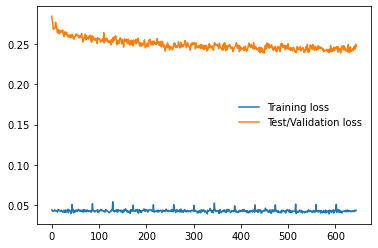

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv11 = nn.Conv2d(in_channels=num_output_channels, out_channels=40, kernel_size=5, padding=2)
        self.conv12 = nn.Conv2d(40, 40, 5, padding=2)
        self.batch1 = nn.BatchNorm2d(40)
        self.pool1  = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv21 = nn.Conv2d(40, 80, 5, padding=2)
        self.conv22 = nn.Conv2d(80, 80, 5, padding=2)
        self.batch2 = nn.BatchNorm2d(80)
        self.pool2  = nn.MaxPool2d(2,2)

        
        # Transitioning from Conv ===> Linear
        # 16 is the number of output channels in the previous conv layer.
        
        self.fc1 = nn.Linear(80 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(classes))
        self.dropconv = nn.Dropout(0.2)
        self.dropfc = nn.Dropout(0.5)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.batch1(x)
        x = self.pool1(x)
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.batch2(x)
        x = self.pool2(x)
        x = x.view(-1, 80 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.dropfc(x)
        x = self.soft(x)
        return x

# init the class 
model = Net()
print(model)
model.eval()
inp = torch.randn((1,1,32,32))
out = model(inp)

model.load_state_dict(torch.load('./models/pictexHelp_103.pt'))
model.train()
import torch.optim as optim

# set parameters
learning_rate = 0.0001
momentum = 0.9

def loss_optim():
    # Loss function: 
    # criterion = nn.CrossEntropyLoss()
    # criterion = nn.MSELoss()
    criterion = nn.NLLLoss()
    
    # Optimizer:
    # optimizer = torch.optim.Adamax(model.parameters(), learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    optimizer = optim.Adam(model.parameters(), learning_rate, amsgrad = True)
    #optimizer = optim.SGD(model.parameters(), learning_rate, momentum)
    
    return criterion, optimizer

criterion, optimizer = loss_optim()
print(criterion)
print(optimizer)

%matplotlib inline
import matplotlib.pyplot as plt
from torch.autograd import Variable


def train_network():
    
    # Choose parameters
    num_epoch = 15
    mini_batch = 10 # previously batch_size
    train_losses, test_losses = [], []
    running_loss = 0
    for epoch in range(num_epoch):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # convert to float bc softmax doesn't work with long
            inputs = torch.tensor(inputs, dtype=torch.float)
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # print statistics
            if i % mini_batch == mini_batch-1:    # print every # of mini-batches
                test_loss = 0
                accuracy = 0
                # begin evaluation of validation loss
                model.eval()
                with torch.no_grad():
                    for inputs_test, labels_test in testloader:
                        if labels_test.size()[0] == batch_size:
                            ps = model.forward(inputs_test)
                            batch_loss = criterion(ps, labels_test)
                            test_loss += batch_loss.item()
                            top_p, top_class = ps.topk(1, dim=1)
                            equals = top_class == labels_test.view(*top_class.shape)
                            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                train_losses.append(running_loss/len(trainloader))
                test_losses.append(test_loss/len(testloader))    
                print(f"|  [Epoch: {epoch + 1}, Batch: {i + 1}]   "
                      f"Train loss: {running_loss/len(trainloader):.3f}  |  "
                      f"Test loss: {test_loss/len(testloader):.3f}  |  "
                      f"Test accuracy: {accuracy/len(testloader):.3f}  |")
                running_loss = 0
                model.train()
            
    
    PATH = './models/pictexHELP_103.pt'
    torch.save(model.state_dict(), PATH)
    return train_losses, test_losses, PATH

def visualize_train(train_losses, test_losses):
     plt.plot(train_losses, label='Training loss')
     plt.plot(test_losses, label='Test/Validation loss')
     plt.legend(frameon=False)
     plt.show()

print("========================================BEGIN TRAINING=======================================")
train_losses, test_losses, PATH = train_network()
print("=========================================END TRAINING========================================")
visualize_train(train_losses, test_losses)